# Segmentación espectral
### Ana Sofía Escobar y Guillermo Furlan

In [3]:
import numpy as np
import cv2
from skimage.segmentation import slic
from skimage.util import img_as_float
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import laplacian as csgraph_laplacian
from sklearn.cluster import KMeans
import math
import matplotlib.pyplot as plt

In [49]:
# Parámetros de la matriz de afinidad
alpha = 1.0
beta = 1.0
sigma = 1.0

In [50]:
#Se plantean metricas de afinidad por medio de un kernel gausseano
def similaridad(x, y, img):
    color = np.linalg.norm(img[int(x[0]), int(x[1])] - img[int(y[0]), int(y[1])])
    posicion = np.linalg.norm(x - y)
    return np.exp(-0.5 * (alpha * color + beta * posicion) / (sigma ** 2))

In [51]:
# Función para calcular el laplaciano y los eigen valores
def laplaciano(graph_laplacian):
    eigenvals, eigenvcts = np.linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts


In [67]:
def segmentacion(image_path, max_segments):

    #Cargar la imagen y convertirla a RGB
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    im_float = img_as_float(image)

    # Segmentar la imagen usando SLIC esto es para controlar el tamaño de la matriz a mi antojo ya que yo elijo la cantidad de segmentos en la que la imagen
    # y esto controla la matriz rala
    segments = slic(im_float, n_segments=max_segments, sigma=5)

    # Obtener los identificadores únicos de los pixeles
    pixelids = np.unique(segments)
    centers = np.array([np.mean(np.nonzero(segments == i), axis=1) for i in pixelids])

    # Obtener los pares vecinos de los pixeles
    neighbors_right = np.vstack([segments[:, :-1].ravel(), segments[:, 1:].ravel()])
    neighbors_below = np.vstack([segments[:-1, :].ravel(), segments[1:, :].ravel()])
    neighbor_pairs = np.unique(np.hstack([neighbors_right, neighbors_below]), axis=1)

    # Construir la matriz de afinidad W
    W = np.zeros((len(centers), len(centers)))

    for i in range(neighbor_pairs.shape[1]):
        id_0 = neighbor_pairs[0, i]
        id_1 = neighbor_pairs[1, i]
        
        if id_0 < len(centers) and id_1 < len(centers):  # Verificar que los índices estén dentro de los límites
            x0, y0 = centers[int(id_0)]
            x1, y1 = centers[int(id_1)]
            aff = similaridad(np.array([x0, y0]), np.array([x1, y1]), image)
    
            W[int(id_0), int(id_1)] = aff
            W[int(id_1), int(id_0)] = aff

    # Calcular el Laplaciano L del grafo G
    L = csgraph_laplacian(csr_matrix(W), normed=False).toarray()

    # Calcular los autovalores y autovectores del Laplaciano L
    eigenvals, eigenvcts = laplaciano(L)

    # Encontrar el índice del segundo menor autovalor (el menor autovalor siempre es 0)
    seceigenval = np.argsort(eigenvals)[1]

    # El vector de Fiedler es el autovector correspondiente al segundo menor autovalor
    fiedler_vector = eigenvcts[:, seceigenval]

    # Segmentar la imagen en dos componentes (fondo y primer plano) usando los signos del vector de Fiedler
    labels = np.zeros_like(segments)
    
    for i in range(len(pixelids)):
        if fiedler_vector[i] > 0:
            labels[segments == pixelids[i]] = 255
    
    # Imprimir la imagen original y la segmentada
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(im_float)
    ax[0].set_title('Imagen Original')
    ax[0].axis('off')

    ax[1].imshow(labels, cmap='gray')
    ax[1].set_title('Imagen Segmentada')
    ax[1].axis('off')

    plt.show()
    
    return labels

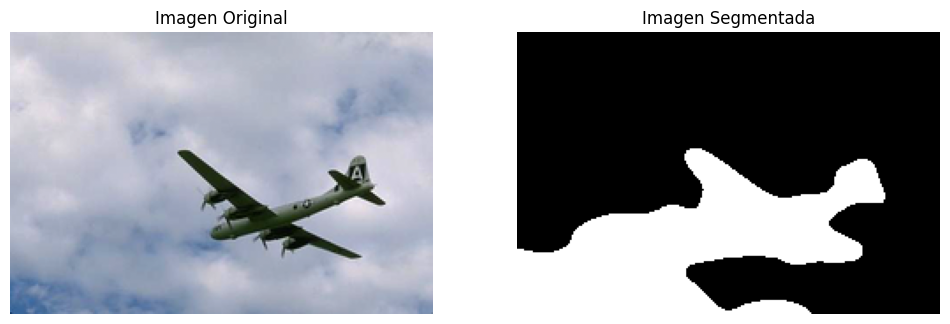

In [68]:
labels = segmentacion("plane_half.png", 3)

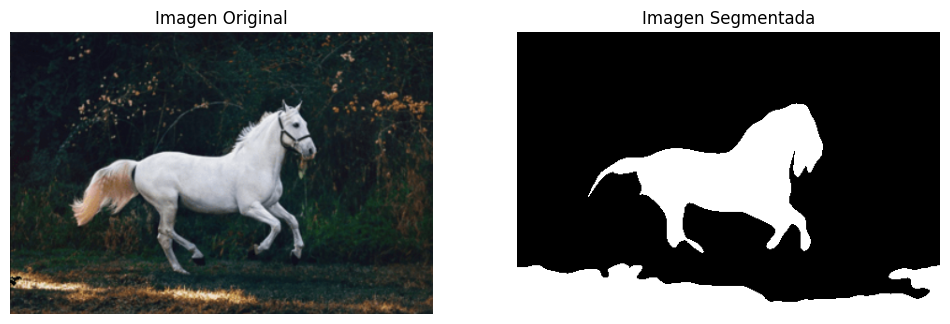

In [69]:
labels = segmentacion("caballo.png", 10)

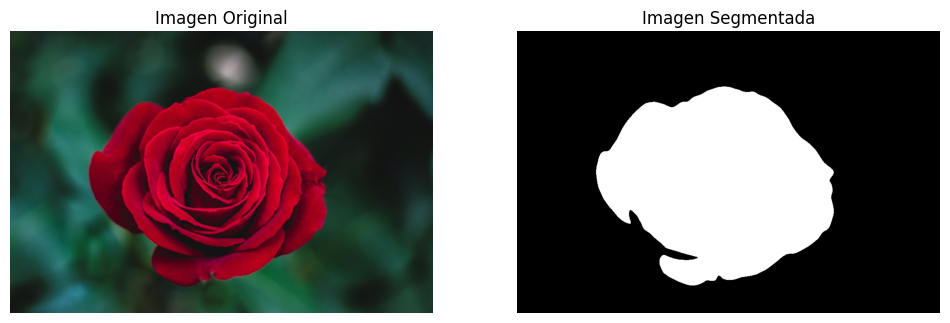

In [70]:
labels = segmentacion("flor.jpg", 3)